In [35]:
import pandas as pd
import tqdm

from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict

%matplotlib inline

# Exploration

In [36]:
df = pd.read_csv('../data/digitiser_dataset.csv', index_col=0)
df = df[df['x_questions']==20]
df.head(10)

,feedback,name,question,round,best_of_name,model_id,user_id,x_questions
0,-1,Lio,1,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
1,-1,Sara,1,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
2,3,Marilou,1,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
3,-1,Chloé,1,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
4,-1,Iluna,2,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
5,3,Mira,2,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
6,-1,Zoë,2,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
7,-1,Helena,2,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
8,-1,June,3,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
9,3,Léa,3,1,True,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20


In [37]:
views = df['name'].value_counts()
views.head()

Anna     3164
Zoé      3071
Lou      2898
Laura    2897
Elize    2894
Name: name, dtype: int64

In [38]:
clicks = df.loc[df['feedback']==3,'name'].value_counts()
clicks.head()

Anna    1224
Lou     1205
Nora    1203
Lili    1159
Ella    1112
Name: name, dtype: int64

In [39]:
clicks_per_view = clicks / views
name_df = pd.DataFrame({'clicks':clicks, 'views':views, 'clicks_per_view':clicks_per_view})
name_df.sort_values('clicks_per_view', ascending=False).head()

,clicks,clicks_per_view,views
Charlie,1.0,1.000000,1
Minne,2.0,0.666667,3
Annabelle,2.0,0.666667,3
Ella,1112.0,0.555445,2002
Nore,501.0,0.524059,956


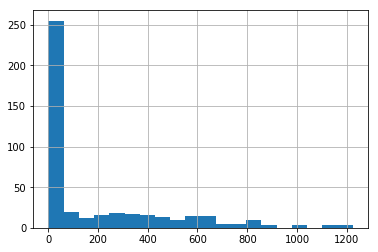

In [40]:
name_df['clicks'].hist(bins=20)

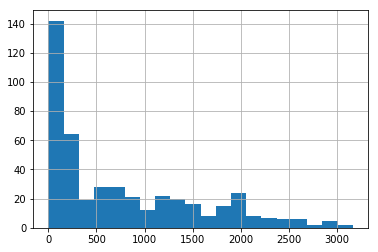

In [41]:
name_df['views'].hist(bins=20)

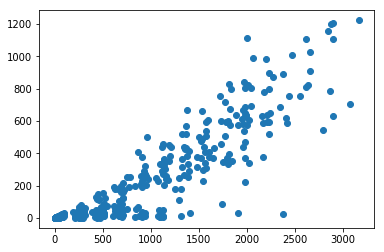

In [42]:
plt.scatter(name_df['views'], name_df['clicks'])

# Baseline


In [43]:
popularity = pd.read_csv('../data/popularity.csv')
popularity.head()

,name,sex,region,year_1995,year_1996,year_1997,year_1998,year_1999,year_2000,year_2001,...,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016
0,Aagje,F,Vlaanderen,0.0,10.0,7.0,6.0,5.0,0.0,12.0,...,10.0,11.0,12.0,11.0,8.0,11.0,7.0,0.0,0.0,0.0
1,Aaliyah,F,Vlaanderen,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,8.0,7.0,14.0,9.0,9.0,7.0,10.0,11.0,8.0,13.0
2,Abigail,F,Vlaanderen,0.0,0.0,8.0,0.0,0.0,0.0,5.0,...,0.0,6.0,7.0,8.0,16.0,11.0,10.0,10.0,11.0,12.0
3,Ada,F,Vlaanderen,0.0,0.0,0.0,0.0,5.0,0.0,6.0,...,12.0,19.0,17.0,20.0,24.0,19.0,28.0,32.0,35.0,27.0
4,Adeline,F,Vlaanderen,15.0,10.0,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,6.0,8.0,0.0,8.0,0.0,12.0


In [44]:
df['question_id'] = df['model_id'] + '_' + df['question'].astype(str)
df['question_id'].head(12)

0     3dxqYZDIqnnbnJRwd9xF_1
1     3dxqYZDIqnnbnJRwd9xF_1
2     3dxqYZDIqnnbnJRwd9xF_1
3     3dxqYZDIqnnbnJRwd9xF_1
4     3dxqYZDIqnnbnJRwd9xF_2
5     3dxqYZDIqnnbnJRwd9xF_2
6     3dxqYZDIqnnbnJRwd9xF_2
7     3dxqYZDIqnnbnJRwd9xF_2
8     3dxqYZDIqnnbnJRwd9xF_3
9     3dxqYZDIqnnbnJRwd9xF_3
10    3dxqYZDIqnnbnJRwd9xF_3
11    3dxqYZDIqnnbnJRwd9xF_3
Name: question_id, dtype: object

In [45]:
most_popular = (
    pd.merge(
        df, 
        popularity, 
        left_on = 'name', 
        right_on = 'name')
     .sort_values('year_2016', ascending=False)
     .groupby('question_id')['name'].first())
clicked = df.sort_values('feedback', ascending=False).groupby('question_id')['name'].first()

In [46]:
most_popular.head()

question_id
00329XrhSh1vtc7swjcP_1     Lucie
00329XrhSh1vtc7swjcP_11    Emily
00329XrhSh1vtc7swjcP_12     Lore
00329XrhSh1vtc7swjcP_13     Emma
00329XrhSh1vtc7swjcP_14     Ella
Name: name, dtype: object

In [47]:
clicked.head()

question_id
00329XrhSh1vtc7swjcP_1        Mona
00329XrhSh1vtc7swjcP_11    Paulien
00329XrhSh1vtc7swjcP_12       Maya
00329XrhSh1vtc7swjcP_13    Phaedra
00329XrhSh1vtc7swjcP_14        Zoé
Name: name, dtype: object

In [48]:
questions = pd.DataFrame({'most_popular':most_popular, 'clicked':clicked})
questions.head()

,clicked,most_popular
question_id,,
00329XrhSh1vtc7swjcP_1,Mona,Lucie
00329XrhSh1vtc7swjcP_11,Paulien,Emily
00329XrhSh1vtc7swjcP_12,Maya,Lore
00329XrhSh1vtc7swjcP_13,Phaedra,Emma
00329XrhSh1vtc7swjcP_14,Zoé,Ella


In [49]:
(questions['clicked'] == questions['most_popular']).mean()

0.36012228260869567

The popularity based recommender guesses clicks correctly **36%** of the time

# Modeling for a single user

In [50]:
feature_df = pd.read_csv('../data/features.csv', index_col=0)

In [51]:
df['target'] = df['feedback'].map({-1:0, 3:1})

In [52]:
model_id = df['model_id'].sample().iloc[0]
model_df = pd.merge(df[df['model_id']==model_id], feature_df, on='name')
model_df.head(12)

,feedback,name,question,round,best_of_name,model_id,user_id,x_questions,question_id,target,...,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016
0,-1,Lara,1,1,False,1mDluv8NEhI5536qdfkm,0XaNPqsu2qIZK0hDyeno,20,1mDluv8NEhI5536qdfkm_1,0,...,145.0,111.0,91.0,110.0,90.0,105.0,86.0,99.0,85.0,88.0
1,-1,Lili,1,1,False,1mDluv8NEhI5536qdfkm,0XaNPqsu2qIZK0hDyeno,20,1mDluv8NEhI5536qdfkm_1,0,...,30.0,25.0,38.0,34.0,43.0,46.0,43.0,55.0,34.0,31.0
2,-1,Victoria,1,1,False,1mDluv8NEhI5536qdfkm,0XaNPqsu2qIZK0hDyeno,20,1mDluv8NEhI5536qdfkm_1,0,...,41.0,36.0,43.0,52.0,58.0,60.0,75.0,59.0,52.0,56.0
3,3,Annabel,1,1,False,1mDluv8NEhI5536qdfkm,0XaNPqsu2qIZK0hDyeno,20,1mDluv8NEhI5536qdfkm_1,1,...,19.0,24.0,26.0,19.0,38.0,22.0,31.0,34.0,23.0,28.0
4,3,Elise,2,1,True,1mDluv8NEhI5536qdfkm,0XaNPqsu2qIZK0hDyeno,20,1mDluv8NEhI5536qdfkm_2,1,...,260.0,296.0,323.0,317.0,313.0,318.0,341.0,351.0,317.0,308.0
5,-1,Chaimae,2,1,False,1mDluv8NEhI5536qdfkm,0XaNPqsu2qIZK0hDyeno,20,1mDluv8NEhI5536qdfkm_2,0,...,15.0,10.0,9.0,12.0,7.0,0.0,8.0,0.0,0.0,0.0
6,-1,Nell,2,1,False,1mDluv8NEhI5536qdfkm,0XaNPqsu2qIZK0hDyeno,20,1mDluv8NEhI5536qdfkm_2,0,...,25.0,22.0,17.0,27.0,30.0,39.0,43.0,53.0,60.0,47.0
7,-1,Liv,2,1,False,1mDluv8NEhI5536qdfkm,0XaNPqsu2qIZK0hDyeno,20,1mDluv8NEhI5536qdfkm_2,0,...,45.0,38.0,47.0,69.0,84.0,107.0,108.0,119.0,163.0,168.0
8,-1,Martha,3,1,False,1mDluv8NEhI5536qdfkm,0XaNPqsu2qIZK0hDyeno,20,1mDluv8NEhI5536qdfkm_3,0,...,15.0,18.0,16.0,25.0,35.0,38.0,35.0,41.0,36.0,36.0
9,3,Laure,3,1,False,1mDluv8NEhI5536qdfkm,0XaNPqsu2qIZK0hDyeno,20,1mDluv8NEhI5536qdfkm_3,1,...,88.0,84.0,76.0,90.0,69.0,96.0,78.0,84.0,79.0,87.0


In [53]:
features = ['lin_trend_a', 'score_classic', 'dtw_vlaanderen_1',
       'dtw_vlaanderen_2', 'score_typical_vl', 'score_typical_wal',
       'score_typical_bxl', 'year_1995', 'year_2000',  'year_2005', 'year_2010', 'year_2015', 'year_2016']

In [54]:
X = model_df[features]
y = model_df['target']

In [55]:
clf = RandomForestClassifier()

In [56]:
param_grid = {'n_estimators':[200], 'max_depth':[3]}
clf_gs = GridSearchCV(clf,param_grid=param_grid, cv=4, n_jobs=-1)
clf_gs.fit(X,y)
clf_gs.best_params_

{'max_depth': 3, 'n_estimators': 200}

## Find top 30

In [57]:
X_other = feature_df.loc[~feature_df['name'].isin(model_df['name']), features]
name_other = feature_df.loc[~feature_df['name'].isin(model_df['name']), 'name']

In [58]:
best_clf = clf_gs.best_estimator_
y_other = best_clf.predict_proba(X_other)[:,1]

In [59]:
results = pd.DataFrame({'name':name_other, 'score':y_other})

In [60]:
results.sort_values('score', ascending=False)['name'].head(30)

600         Laura
361       Florine
536         Julie
544       Justine
993        Sophie
61          Anaïs
286        Emilie
605        Laurie
951         Sarah
207         Célia
24          Aline
772       Maureen
391    Gwendoline
881       Ophélie
203       Coralie
755        Marion
200      Clémence
325         Fanny
41       Amandine
352        Flavie
4         Adeline
800      Michelle
195      Clarisse
830       Mélanie
991         Sofie
733         Manon
22         Alicia
740        Margot
915        Romane
45          Ambre
Name: name, dtype: object

## Estimate model performance

In [61]:
cv_score = cross_val_predict(best_clf,X,y, cv=8,n_jobs=-1, method='predict_proba')[:,1]

In [62]:
model_df['cv_score'] = cv_score

In [63]:
%time best_score = (model_df.sort_values('cv_score', ascending=False).groupby('question_id')['name'].first())
%time clicked = model_df.sort_values('feedback', ascending=False).groupby('question_id')['name'].first()

CPU times: user 4.21 ms, sys: 2.14 ms, total: 6.35 ms
Wall time: 5.33 ms
CPU times: user 2.29 ms, sys: 460 µs, total: 2.75 ms
Wall time: 2.42 ms


In [64]:
questions = pd.DataFrame({'best_score':best_score, 'clicked':clicked})
questions

,best_score,clicked
question_id,,
1mDluv8NEhI5536qdfkm_1,Victoria,Annabel
1mDluv8NEhI5536qdfkm_11,Nora,Maud
1mDluv8NEhI5536qdfkm_12,Emma,Emma
1mDluv8NEhI5536qdfkm_13,Marie,Marie
1mDluv8NEhI5536qdfkm_14,Céline,Céline
1mDluv8NEhI5536qdfkm_16,Hannah,Felien
1mDluv8NEhI5536qdfkm_17,Nina,Lauren
1mDluv8NEhI5536qdfkm_18,Ella,Ella
1mDluv8NEhI5536qdfkm_19,Louise,Elisa


In [65]:
(questions['clicked'] == questions['best_score']).mean()

0.375

## Estimate performance on many users

In [66]:
correctness = {}
for model_id in tqdm.tqdm_notebook(df['model_id'].drop_duplicates().sample(50)):
    model_df = pd.merge(df[df['model_id']==model_id], feature_df, on='name', how='inner')
    X = model_df[features]
    y = model_df['target']
    #clf_gs.fit(X,y)
    cv_score = cross_val_predict(best_clf,X,y, cv=3, method='predict_proba', n_jobs=-1)[:,1]
    model_df['cv_score'] = cv_score
    best_score = (model_df.sort_values('cv_score', ascending=False).groupby('question_id')['name'].first())
    clicked = model_df.sort_values('feedback', ascending=False).groupby('question_id')['name'].first()
    questions = pd.DataFrame({'best_score':best_score, 'clicked':clicked})
    correctness[model_id] = (questions['clicked'] == questions['best_score']).mean()
correctness = pd.Series(correctness)

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

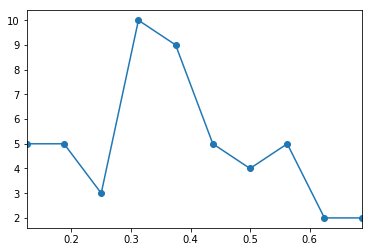

In [67]:
pd.Series(correctness).value_counts().sort_index().plot(marker='o')

In [68]:
correctness.mean()

0.36875000000000002